# Figure 3 - Panel G

In [1]:
# Enter path to PGM package directory
# This pacakge can be downloaded at https://github.com/jertubiana/PGM
# Please follow installation instructions in README.md
PGM_dir_path = ''  

In [27]:
import os, sys
import torch
import numpy as np
import h5py
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import set_num_threads
from numba import njit,prange
set_num_threads(8) # Set the number of cores. Must be executed before importing numpy&numba.

sys.path.append(PGM_dir_path + '/source/')
sys.path.append(PGM_dir_path + '/utilities/')
import RBM_utils
import rbm, utilities

from zebrafish_rtrbm.models.RBM import RBM
from zebrafish_rtrbm.models.RTRBM import RTRBM

from zebrafish_rtrbm.utils.data_methods import reshape
from zebrafish_rtrbm.utils.metrics import get_spearmanr
from zebrafish_rtrbm.utils.metrics import kurtosis_per_t

In [3]:
def load_dataset(path2dataset):
    f = h5py.File(path2dataset, 'r')
    labels = f['Data']['Brain']['Labels'][:].T.astype('bool')
    Coordinates = f['Data']['Brain']['Coordinates'][:].T # Spatial coordinates
    Labels = f['Data']['Brain']['Labels'][:].T.astype('bool')
    Spikes = f['Data']['Brain']['Analysis']['ThresholdedSpikes'][:].astype('bool')
    f.close()

    mask = Labels.max(-1) # Discard neurons not mapped to Zbrain atlas.
    Spikes = Spikes[:,mask]
    Coordinates = Coordinates[mask]

    return Spikes,Coordinates

## Data splitting

The train/test split is defined by dividing the recording, with a length of T, into 10 chronological segments of equal length. The train batch consists of segments 1, 3, 4, 5, 8, 9, and 10, while the test batch consists of segments 2, 6, and 7. Since the neural recordings are from separate fish that are in different brain states at the beginning and during the recordings, it is not necessary for each fish to have a different train/test split segments.

In [16]:
list_datasets = [
    'fish1_20180706_Run04',
    'fish2_20180911_Run01',
    'fish3_20180912_Run01',
    'fish4_20180913_Run01',
    'fish5_20190109_Run04',
    'fish6_20181206_Run03',
    'fish7_20190102_Run01',
    'fish8_20181206_Run05',
]

T = {
'fish1_20180706_Run04':16,
'fish2_20180911_Run01':15,
'fish3_20180912_Run01':15,
'fish4_20180913_Run01':14,
'fish5_20190109_Run04':15,
'fish6_20181206_Run03':16,
'fish7_20190102_Run01':15,
'fish8_20181206_Run05':16,
}

n_batches_test = {
'fish1_20180706_Run04':103,
'fish2_20180911_Run01':120,
'fish3_20180912_Run01':111,
'fish4_20180913_Run01':107,
'fish5_20190109_Run04':150,
'fish6_20181206_Run03':68,
'fish7_20190102_Run01':150,
'fish8_20181206_Run05':68,
}

n_hidden_units = {
'fish1_20180706_Run04':200,
'fish2_20180911_Run01':200,
'fish3_20180912_Run01':200,
'fish4_20180913_Run01':200,
'fish5_20190109_Run04':100,
'fish6_20181206_Run03':200,
'fish7_20190102_Run01':100,
'fish8_20181206_Run05':100,
                }

In [5]:
def train_test_split(data):
    batch_size = data.shape[1] // 10
    train = torch.zeros(data.shape[0], batch_size, 7)
    test = torch.zeros(data.shape[0], batch_size, 3)
    batch_index_shuffled = [0, 2, 3, 4, 7, 8, 9, 1, 5, 6]
    i = 0

    for batch in range(10):
        j = batch_index_shuffled[batch]
        if batch < 7:
            train[:, :, batch] = data[:, j * batch_size:(j + 1) * batch_size]
        if batch >= 7:
            test[:, :, batch-7] = data[:, j * batch_size:(j + 1) * batch_size]

    return train, test

## Model inference

In [19]:
data_dir = '../data/figure3_zebrafish'  # Directory path to save the model files to

In [ ]:
n_resample = 1
n_neurons = 1000
rs_v_cRBM_list, rs_vv_cRBM_list, rs_vvt_cRBM_list, rs_hht_cRBM_list, rs_v_rtrbm_list, rs_vv_rtrbm_list, rs_vvt_rtrbm_list, rs_hht_rtrbm_list = [[] for _ in range(8)]
p_v_cRBM_list, p_vv_cRBM_list, p_vvt_cRBM_list, p_hht_cRBM_list, p_v_rtrbm_list, p_vv_rtrbm_list, p_vvt_rtrbm_list, p_hht_rtrbm_list = [[] for _ in range(8)]

effective_nr_HU_cRBM = []
effective_nr_HU_rtrbm = []

def cl(input_list):
    new_list = []
    for i in range(8):
        temp_list = []
        for j in range(10):
            temp_list += [input_list[i + 8 * j]]
        new_list += [np.stack(temp_list).flatten()]
    return new_list

for resample in tqdm(range(n_resample)):
    # for i, dataset_idx in enumerate([0, 1, 2, 3, 4, 5, 6, 7]):
    for i, dataset_idx in enumerate([3]):

        dataset = list_datasets[dataset_idx]
        Spikes, _ = load_dataset(data_dir + '/fish%s/rbm_%s.h5'%(dataset_idx+1, dataset))

        path2rtrbm = models_dir + '/fish%s/rtrbm_%s_transfer'%(dataset_idx+1, dataset)
        path2crbm = models_dir + '/fish%s/rbm_%s.data'%(dataset_idx+1, dataset)
        path2crbm_transfer = models_dir + '/fish%s/rbm_%s_transfer.data'%(dataset_idx+1, dataset)

        try:
            RBM = RBM_utils.loadRBM(path2crbm_transfer)
        except:
            RBM = RBM_utils.loadRBM(path2crbm)

        rtrbm = torch.load(path2rtrbm)

        _, test = train_test_split(torch.tensor(Spikes.T))
        test = reshape(reshape(test), T=T[dataset], n_batches=n_batches_test[dataset])

        ht_cRBM = RBM.mean_hiddens(reshape(test).T).T
        vt, ht_rtrbm = test.clone().detach(), rtrbm._parallel_recurrent_sample_r_given_v(test.to(rtrbm.device))
        vt, vs_rtrbm, vs_cRBM, hs_rtrbm, hs_cRBM = torch.load(inferred_dir + '/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, resample))
        
        index = np.random.permutation(vt.shape[0])
        nrun = vt.shape[0] // n_neurons

        rs_v_cRBM, rs_vv_cRBM, rs_vvt_cRBM, rs_hht_cRBM, rs_v_rtrbm, rs_vv_rtrbm, rs_vvt_rtrbm, rs_hht_rtrbm = [np.zeros(nrun) for _ in range(8)]
        p_v_cRBM, p_vv_cRBM, p_vvt_cRBM, p_hht_cRBM, p_v_rtrbm, p_vv_rtrbm, p_vvt_rtrbm, p_hht_rtrbm = [np.zeros(nrun) for _ in range(8)]
        for run in range(nrun):
            idx = index[(run*n_neurons):((run+1)*n_neurons)]
            rs, p = get_spearmanr(vt, vs_cRBM, vs_rtrbm, ht_cRBM, ht_rtrbm, hs_cRBM, hs_rtrbm, n_neurons=n_neurons, idx=idx)
            rs_v_cRBM[run], rs_vv_cRBM[run], rs_vvt_cRBM[run], rs_hht_cRBM[run], rs_v_rtrbm[run], rs_vv_rtrbm[run], rs_vvt_rtrbm[run], rs_hht_rtrbm[run] = rs
            p_v_cRBM[run], p_vv_cRBM[run], p_vvt_cRBM[run], p_hht_cRBM[run], p_v_rtrbm[run], p_vv_rtrbm[run], p_vvt_rtrbm[run], p_hht_rtrbm[run] = p

        rs_v_cRBM_list += [rs_v_cRBM]
        rs_vv_cRBM_list += [rs_vv_cRBM]
        rs_vvt_cRBM_list += [rs_vvt_cRBM]
        rs_hht_cRBM_list += [rs_hht_cRBM]
        rs_v_rtrbm_list += [rs_v_rtrbm]
        rs_vv_rtrbm_list += [rs_vv_rtrbm]
        rs_vvt_rtrbm_list += [rs_vvt_rtrbm]
        rs_hht_rtrbm_list += [rs_hht_rtrbm]
    
        effective_nr_HU_cRBM += [kurtosis_per_t(ht_cRBM)]
        effective_nr_HU_rtrbm += [kurtosis_per_t(ht_rtrbm.cpu())]


## Plot

Significance of Spearman correlations over a subset of 1000 random neurons and N repetitions, such that N=n_v//1000. Using overlap confidence interval as a measure of significance.


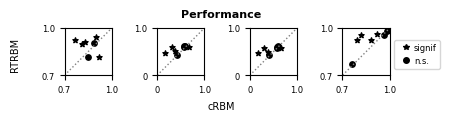

In [7]:
rs_v_cRBM_list, rs_vv_cRBM_list, rs_vvt_cRBM_list, rs_hht_cRBM_list, rs_v_rtrbm_list, rs_vv_rtrbm_list, rs_vvt_rtrbm_list, rs_hht_rtrbm_list, effective_nr_HU_cRBM, effective_nr_HU_rtrbm = torch.load()
def cl(input_list):
    new_list = []
    for i in range(8):
        temp_list = []
        for j in range(10):
            temp_list += [input_list[i + 8 * j]] 
        new_list += [np.stack(temp_list).flatten()]
    return new_list

def calculate_confidence_bound_and_overlap(x, n_std = 2):
    n_var = x.shape[0]
    means = np.mean(x, axis=1)
    stds = np.std(x, axis=1)
    confidence_bounds = np.array([means - n_std * stds, means + n_std * stds]).T
    
    #print('mean: %s, std: %s, confidence bound: %s'%(means, stds, confidence_bounds))
    overlap = np.zeros((n_var, n_var), dtype=bool)
    for i in range(n_var):
        for j in range(i + 1, n_var):
            overlap[i, j] = not (confidence_bounds[i, 0] > confidence_bounds[j, 1] or confidence_bounds[i, 1] < confidence_bounds[j, 0])
    idx = np.triu_indices(n_var, 1)                        
    return overlap[idx]

def plot_performance_model_stat(r_cRBM, r_rtrbm, p_value=None, ax=None, title_stat='$v_i$', x_label=True, y_label=True, significance='OCI'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    X = [r'$1$', r'$2$', r'$3$', r'$4$', r'$5$', r'$6$', r'$7$', r'$8$']
    fish = np.arange(len(X)) + 1
    
    if p_value is None:
        #print('Using bootstrap with ranksum test on r values')
        p_value = np.zeros([fish.shape[0]])
        overlap = np.zeros([fish.shape[0]], dtype=bool)

        for f in range(fish.shape[0]):
            _, p_value[f] = ranksums(r_cRBM[f], r_rtrbm[f])
            overlap[f] = calculate_confidence_bound_and_overlap(np.stack([r_cRBM[f], r_rtrbm[f]]), n_std=2)
    if significance == 'ranksums':
        significant = (p_value < 0.05)
    elif significance == 'OCI': # overlap confidence interval
        significant = abs(overlap - 1)

    ax.scatter(np.array([np.mean(r_cRBM[i]) for i in range(8)])[significant == 0], np.array([np.mean(r_rtrbm[i]) for i in range(8)])[significant == 0], s=15, c='black', marker='o')
    ax.scatter(np.array([np.mean(r_cRBM[i]) for i in range(8)])[significant == 1], np.array([np.mean(r_rtrbm[i]) for i in range(8)])[significant == 1], s=15, c='black', marker='*')
    ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
#     ax.set_aspect('equal')
    
    if ax is not None:
        return ax
    
print('Significance of Spearman correlations over a subset of 1000 random neurons and N repetitions, such that N=n_v//1000. Using overlap confidence interval as a measure of significance.')
fig, ax = plt.subplots(1, 4, figsize=(8, 4))
ax[0] = plot_performance_model_stat(cl(rs_v_cRBM_list), cl(rs_v_rtrbm_list), ax = ax[0], title_stat='$v_i$', significance='OCI')
ax[0].set_xlim([0.7, 1])
ax[0].set_ylim([0.7, 1])
ax[0].set_xticks([0.7, 1])
ax[0].set_yticks([0.7, 1])
ax[0].tick_params(labelsize=6)
ax[0].set_box_aspect(1)

ax[1] = plot_performance_model_stat(cl(rs_vv_cRBM_list), cl(rs_vv_rtrbm_list), ax = ax[1], title_stat='$v_iv_j$', significance='OCI')
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
ax[1].set_xticks([0, 1.0])
ax[1].set_yticks([0, 1.0])
ax[1].set_xticklabels(['0', '1.0'])
ax[1].set_yticklabels(['0', '1.0'])
ax[1].tick_params(labelsize=6)
ax[1].set_box_aspect(1)

ax[2] = plot_performance_model_stat(cl(rs_vvt_cRBM_list), cl(rs_vvt_rtrbm_list), ax = ax[2], title_stat='$v_i^{[t]}v_j^{[t+1]}$', significance='OCI')
ax[2].set_xlim([0, 1.0])
ax[2].set_ylim([0, 1.0])
ax[2].set_xticks([0, 1.0])
ax[2].set_yticks([0, 1.0])
ax[2].set_xticklabels(['0', '1.0'])
ax[2].set_yticklabels(['0', '1.0'])
ax[2].tick_params(labelsize=6)
ax[2].set_box_aspect(1)

ax[3] = plot_performance_model_stat(cl(rs_hht_cRBM_list), cl(rs_hht_rtrbm_list), ax = ax[3], title_stat='$h_i^{[t]}h_j^{[t+1]}$', significance='OCI')
ax[3].set_xlim([0.7, 1])
ax[3].set_ylim([0.7, 1])
ax[3].set_xticks([0.7, 1])
ax[3].set_yticks([0.7, 1])
ax[3].tick_params(labelsize=6)
ax[3].set_box_aspect(1)

lines = []
labels = []
marker = ['*', 'o']
lines += [Line2D([0], [0], color='black', linewidth=1, markersize=4, marker=m, linestyle='') for m in marker]
labels += ['signif', 'n.s.']

fig.subplots_adjust(right=0.88, wspace=0.5, hspace=0, top=0.8, bottom=0.35)

fig.legend(lines, labels, bbox_to_anchor=(0.985, 0.55), loc='center right', ncol=1, bbox_transform=fig.transFigure, handletextpad=0, prop={'size': 6})
fig.supxlabel('cRBM', fontsize=7, x=0.49)
fig.supylabel('RTRBM', fontsize=7, y=0.55)
fig.suptitle('Performance', fontsize=8, fontweight='bold', x=0.49)

# plt.tight_layout()
plt.savefig(path2dir + '/figures/figure3_zebrafish/Performance_comparison_all_fish.png', dpi=1000, transparent=True)
plt.show()
